In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import lightning as L
L.seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Seed set to 42


In [2]:
%reload_ext watermark
%watermark -a "Rodrigo W Pisaia" --iversions --python

Author: Rodrigo W Pisaia

Python implementation: CPython
Python version       : 3.10.16
IPython version      : 8.30.0

pandas    : 2.2.3
torch     : 2.6.0+cu126
lightning : 2.5.0.post0
numpy     : 2.1.3
matplotlib: 3.10.1



In [3]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

In [4]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [5]:
raw_text

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)\n\n"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it\'s going to send the value of my picture \'way up; but I don\'t think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing\'s lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn\'s "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?\n\nWell!--even 

In [6]:
import re
text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)
result

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']

In [7]:
result = re.split(r'([,.]|\s)', text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [8]:
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


In [9]:
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [10]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [11]:
print(len(preprocessed))


4690


In [12]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)


1130


In [13]:
vocab = {token:integer for integer, token in enumerate(all_words)}
vocab

{'!': 0,
 '"': 1,
 "'": 2,
 '(': 3,
 ')': 4,
 ',': 5,
 '--': 6,
 '.': 7,
 ':': 8,
 ';': 9,
 '?': 10,
 'A': 11,
 'Ah': 12,
 'Among': 13,
 'And': 14,
 'Are': 15,
 'Arrt': 16,
 'As': 17,
 'At': 18,
 'Be': 19,
 'Begin': 20,
 'Burlington': 21,
 'But': 22,
 'By': 23,
 'Carlo': 24,
 'Chicago': 25,
 'Claude': 26,
 'Come': 27,
 'Croft': 28,
 'Destroyed': 29,
 'Devonshire': 30,
 'Don': 31,
 'Dubarry': 32,
 'Emperors': 33,
 'Florence': 34,
 'For': 35,
 'Gallery': 36,
 'Gideon': 37,
 'Gisburn': 38,
 'Gisburns': 39,
 'Grafton': 40,
 'Greek': 41,
 'Grindle': 42,
 'Grindles': 43,
 'HAD': 44,
 'Had': 45,
 'Hang': 46,
 'Has': 47,
 'He': 48,
 'Her': 49,
 'Hermia': 50,
 'His': 51,
 'How': 52,
 'I': 53,
 'If': 54,
 'In': 55,
 'It': 56,
 'Jack': 57,
 'Jove': 58,
 'Just': 59,
 'Lord': 60,
 'Made': 61,
 'Miss': 62,
 'Money': 63,
 'Monte': 64,
 'Moon-dancers': 65,
 'Mr': 66,
 'Mrs': 67,
 'My': 68,
 'Never': 69,
 'No': 70,
 'Now': 71,
 'Nutley': 72,
 'Of': 73,
 'Oh': 74,
 'On': 75,
 'Once': 76,
 'Only': 77,
 '

In [14]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i > 20:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)


In [15]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
        
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
                                
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [17]:
tokenizer = SimpleTokenizerV1(vocab)

text = "Hello, do you like tea. Is this-- a test?"

tokenizer.encode(text)

KeyError: 'Hello'

The above produces an error because the word "Hello" is not contained in the vocabulary
To deal with such cases, we can add special tokens like "<|unk|>" to the vocabulary to represent unknown words
Since we are already extending the vocabulary, let's add another token called "<|endoftext|>" which is used in GPT-2 training to denote the end of a text (and it's also used between concatenated text, like if our training datasets consists of multiple articles, books, etc.)

In [18]:
# NOTE including the special tokens in the vocabulary
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [19]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int 
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [20]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)


Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [21]:
encoded_text = tokenizer.encode(text)
print(encoded_text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


In [22]:
tokenizer.decode([1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7])

# tokenizer.decode(encoded_text)

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

---
---
# Byte Pair Encoding (GPT-2)
---
---
* it allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words

* For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges

In [23]:
import importlib
import tiktoken
importlib.metadata.version("tiktoken")

'0.9.0'

In [24]:
tokenizer = tiktoken.get_encoding("gpt2")

text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces "
    "of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]


In [25]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


---
---
# Data sampling with a sliding window
---
---

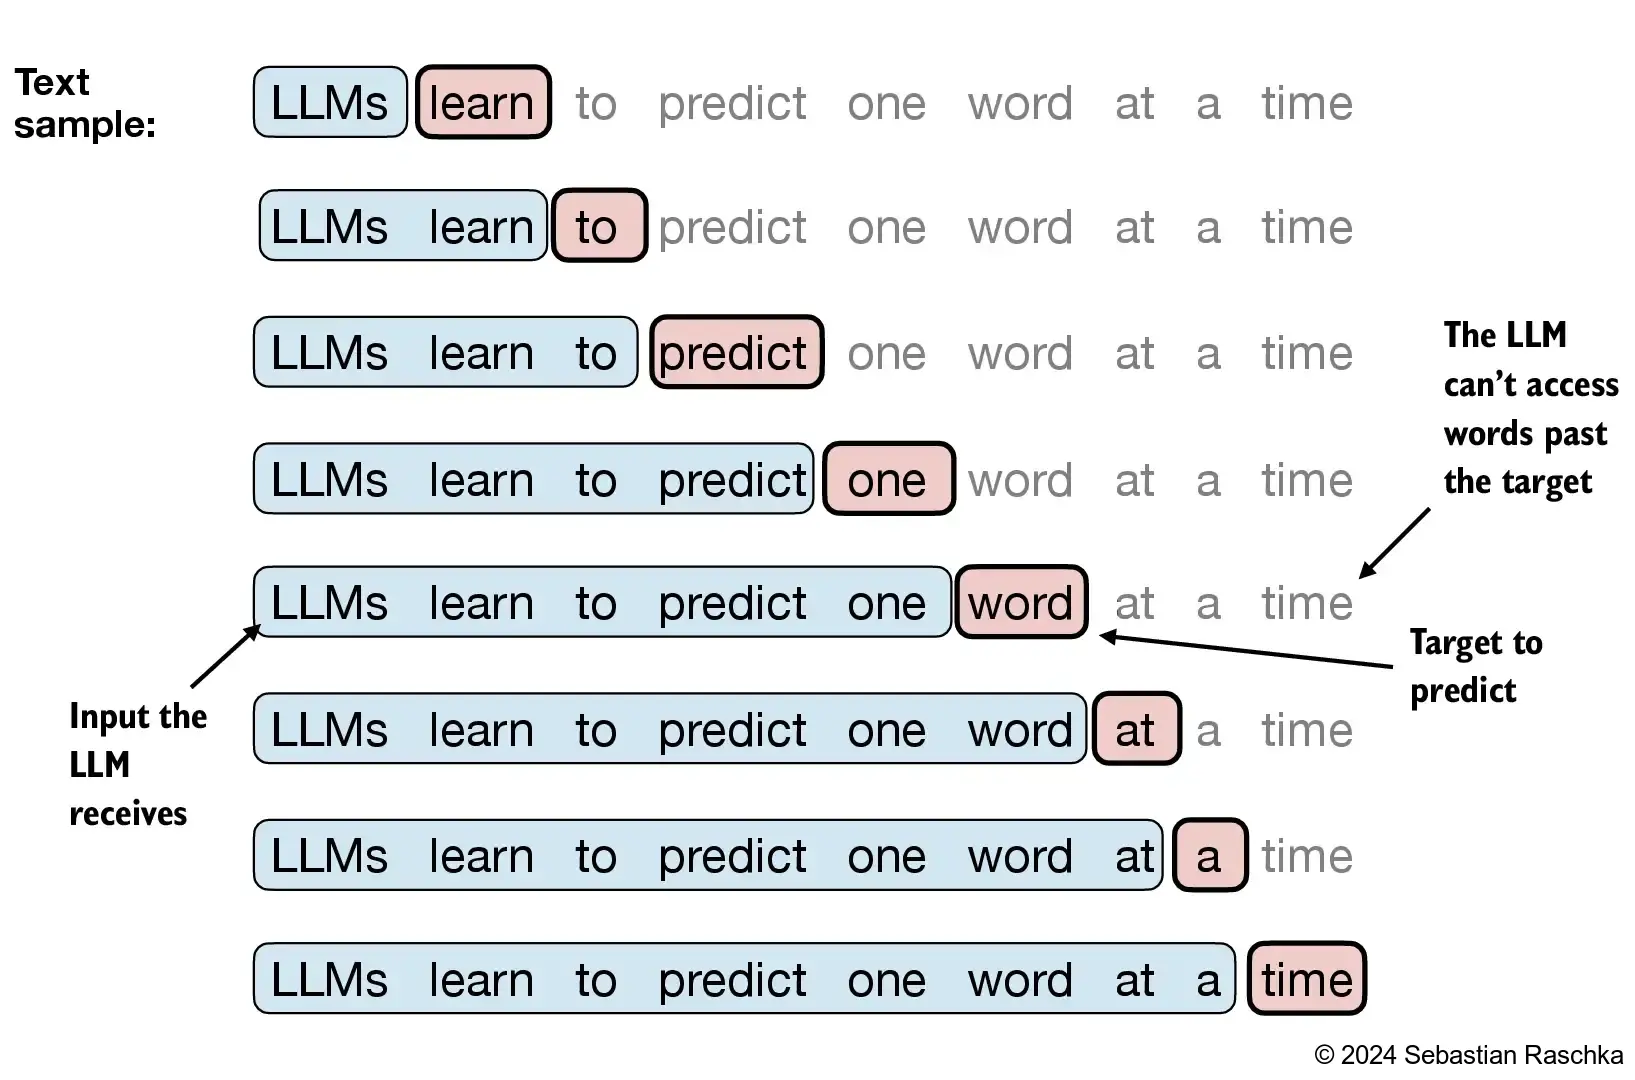

In [26]:
with open("./the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


In [27]:
enc_sample = enc_text[:50]
enc_sample

[40,
 367,
 2885,
 1464,
 1807,
 3619,
 402,
 271,
 10899,
 2138,
 257,
 7026,
 15632,
 438,
 2016,
 257,
 922,
 5891,
 1576,
 438,
 568,
 340,
 373,
 645,
 1049,
 5975,
 284,
 502,
 284,
 3285,
 326,
 11,
 287,
 262,
 6001,
 286,
 465,
 13476,
 11,
 339,
 550,
 5710,
 465,
 12036,
 11,
 6405,
 257,
 5527,
 27075,
 11]

In [28]:
context_size =4
x = enc_sample[:context_size]
# y = enc_sample[1:context_size+1]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [40, 367, 2885, 1464]
y:      [367, 2885, 1464, 1807]


In [29]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    
    print(context, "---->", desired)

[40] ----> 367
[40, 367] ----> 2885
[40, 367, 2885] ----> 1464
[40, 367, 2885, 1464] ----> 1807


In [30]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

I ---->  H
I H ----> AD
I HAD ---->  always
I HAD always ---->  thought


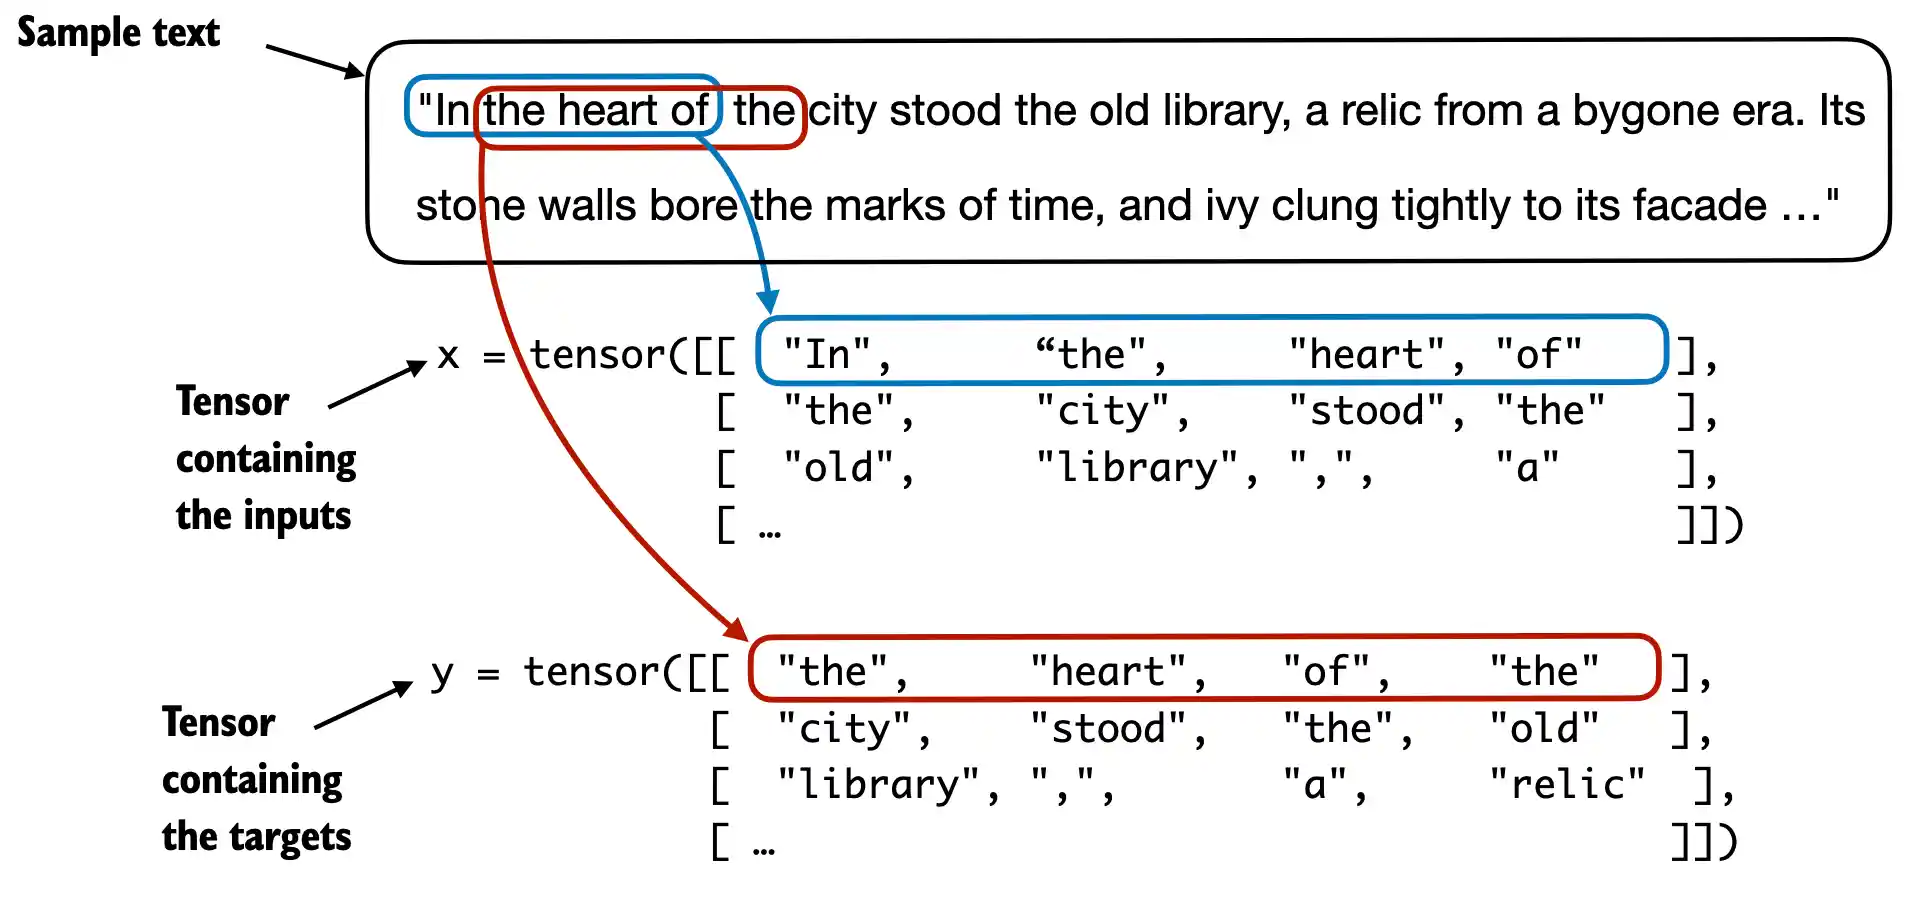

In [31]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(torch.utils.data.Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(input_chunk)
            self.target_ids.append(target_chunk)
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [32]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [37]:
# tokenizer = tiktoken.get_encoding("gpt2")
# max_length = 4
# stride = 1
# batch_size=1,
# shuffle=False
# drop_last=True

# dataset = GPTDatasetV1(
#     txt=raw_text, tokenizer=tokenizer, max_length=max_length, stride=stride
# )


def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [41]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[[tensor([40]), tensor([367]), tensor([2885]), tensor([1464])], [tensor([367]), tensor([2885]), tensor([1464]), tensor([1807])]]


In [42]:
second_batch = next(data_iter)
print(second_batch)

[[tensor([367]), tensor([2885]), tensor([1464]), tensor([1807])], [tensor([2885]), tensor([1464]), tensor([1807]), tensor([3619])]]


In [43]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 [tensor([   40,  1807, 10899, 15632,   922,   568,  1049,   284]), tensor([ 367, 3619, 2138,  438, 5891,  340, 5975, 3285]), tensor([2885,  402,  257, 2016, 1576,  373,  284,  326]), tensor([1464,  271, 7026,  257,  438,  645,  502,   11])]

Targets:
 [tensor([ 367, 3619, 2138,  438, 5891,  340, 5975, 3285]), tensor([2885,  402,  257, 2016, 1576,  373,  284,  326]), tensor([1464,  271, 7026,  257,  438,  645,  502,   11]), tensor([ 1807, 10899, 15632,   922,   568,  1049,   284,   287])]


---
---
# Creating token Embeddings
---
---

In [46]:
inputs_ids = torch.tensor([2,3,5,1])
vocab_size = 6
output_dim = 3
torch.manual_seed(123)
embedding_layer = nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [49]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


In [52]:
print(embedding_layer(inputs_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


## Embeddings vs Matmul

### Using nn.Embedding

In [58]:
idx = torch.tensor([2,3,1])
num_idx = max(idx)+1
print(num_idx)
out_dim=5

tensor(4)


In [57]:
torch.manual_seed(123)
embedding = torch.nn.Embedding(num_idx, out_dim)
embedding.weight

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.3035, -0.5880,  1.5810],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015],
        [ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953]], requires_grad=True)

In [59]:
embedding(torch.tensor([1]))

tensor([[ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

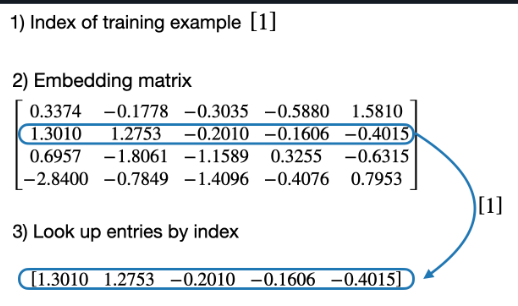

In [64]:
idx = torch.tensor([2,3,1])
embedding(idx)

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

### Using nn.Linear

In [77]:
onehot = torch.nn.functional.one_hot(idx)
onehot

tensor([[0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0]])

tensor([[0, 0, 1, 0], >>2
        [0, 0, 0, 1], >>3
        [0, 1, 0, 0]] >>1
        )

In [78]:
torch.manual_seed(123)
linear = torch.nn.Linear(num_idx, out_dim, bias=False)
linear.weight

Parameter containing:
tensor([[-0.2039,  0.0166, -0.2483,  0.1886],
        [-0.4260,  0.3665, -0.3634, -0.3975],
        [-0.3159,  0.2264, -0.1847,  0.1871],
        [-0.4244, -0.3034, -0.1836, -0.0983],
        [-0.3814,  0.3274, -0.1179,  0.1605]], requires_grad=True)

In [79]:
linear.weight = torch.nn.Parameter(embedding.weight.T)
linear.weight

Parameter containing:
tensor([[ 0.3374,  1.3010,  0.6957, -2.8400],
        [-0.1778,  1.2753, -1.8061, -0.7849],
        [-0.3035, -0.2010, -1.1589, -1.4096],
        [-0.5880, -0.1606,  0.3255, -0.4076],
        [ 1.5810, -0.4015, -0.6315,  0.7953]], requires_grad=True)

In [80]:
linear(onehot.float())

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]], grad_fn=<MmBackward0>)

In [81]:
embedding(idx)

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

---
---
# Encoding word positions
---
---


In [131]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [140]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
inputs = np.array(inputs)

In [141]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 [[   40  1807 10899 15632   922   568  1049   284]
 [  367  3619  2138   438  5891   340  5975  3285]
 [ 2885   402   257  2016  1576   373   284   326]
 [ 1464   271  7026   257   438   645   502    11]]

Inputs shape:
 (4, 8)


In [145]:
token_embeddings = token_embedding_layer(torch.tensor(inputs))
token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.shape
# uncomment & execute the following line to see how the embeddings look like
# print(token_embeddings)

torch.Size([8, 4, 256])

In [146]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [ ]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [ ]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
# print(input_embeddings)

torch.Size([8, 4, 256])
